In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import data from CSV extracted from Cassandra after Pyspark Process
pd.options.display.colheader_justify = 'right'
Data = pd.read_csv('C:\\Users\\santi\\Downloads\\Data.csv')
Data

,date,score_V
0,06/04/2009,0.116971
1,07/04/2009,0.135128
2,08/04/2009,NaN
3,09/04/2009,NaN
4,10/04/2009,NaN
...,...,...
76,21/06/2009,-0.006375
77,22/06/2009,-0.030599
78,23/06/2009,-0.024182
79,24/06/2009,-0.012015


In [201]:
#Aplly best strategy found in EDA for inputting missing data

def seasonal_mean(ts, n, lr=.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

Data['score_V'] = seasonal_mean(Data['score_V'], n=7, lr=1.05)

C:\Users\santi\AppData\Local\Temp\ipykernel_20688\1606205329.py:13: RuntimeWarning:

Mean of empty slice



In [202]:
Data['date']  = pd.to_datetime(Data['date'])

C:\Users\santi\AppData\Local\Temp\ipykernel_20688\1359417632.py:1: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [203]:
Data['date'].max()

Timestamp('2009-12-06 00:00:00')

In [204]:
Data['Weekday'] = Data['date'].dt.strftime('%A')
Data = Data[['score_V','Weekday']]

<AxesSubplot:ylabel='score_V'>

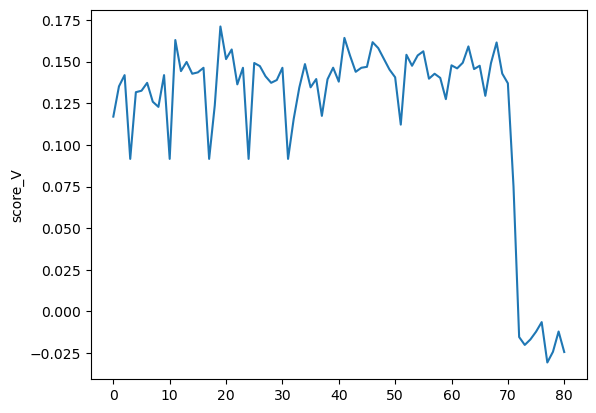

In [205]:
import seaborn
seaborn.lineplot(Data['score_V'])

In [206]:
def weekday_mapping(x):
    week = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6 }

    return week[x]

Data['Weekday'] = Data['Weekday'].apply(weekday_mapping)


C:\Users\santi\AppData\Local\Temp\ipykernel_20688\1743575051.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [207]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(Data.score_V.values, autolag='AIC')
print(f'p-value: {result[1]}')
if result[1]>.05:
    print("Null Hypothesis (HO): Series is non-stationary, or series has a unit root.")
else:
    print("Alternate Hypothesis(HA): Series is stationary, or series has no unit root.")


p-value: 0.6225649561471787
Null Hypothesis (HO): Series is non-stationary, or series has a unit root.


C:\Users\santi\AppData\Local\Temp\ipykernel_20688\2492519450.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Detrend Vader score')

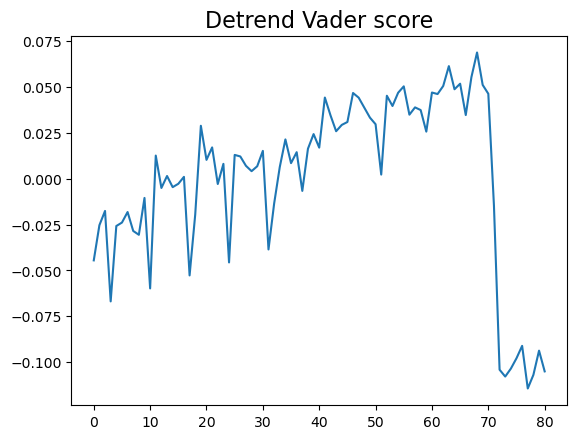

In [208]:
from scipy import signal
Data['score_V'] = signal.detrend(Data['score_V'].values)
plt.plot(Data['score_V'])
plt.title('Detrend Vader score', fontsize=16)

In [209]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
scaler.fit(Data)
Data = scaler.transform(Data)

In [210]:
Data = pd.DataFrame(Data, columns =['score_V','Weekday']
)
Data

,score_V,Weekday
0,-0.953514,-0.024931
1,-0.543072,0.984773
2,-0.376757,-1.034634
3,-1.431918,0.479921
4,-0.552774,1.489624
...,...,...
76,-1.950364,1.489624
77,-2.447458,-1.539486
78,-2.288403,-1.034634
79,-2.006220,-0.529783


In [211]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


steps = 40
data_train = Data[:-steps]
data_test  = Data[-steps:]



forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train["score_V"], exog=data_train["Weekday"])
forecaster

predictions = forecaster.predict(steps=steps, exog=data_test["Weekday"])

<AxesSubplot:>

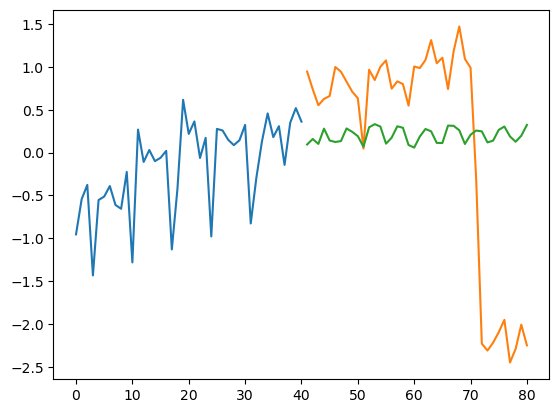

In [212]:
data_train['score_V'].plot(label='train')
data_test['score_V'].plot(label='test')
predictions.plot(label='predictions')

In [213]:
from skforecast.model_selection import grid_search_forecaster
steps = 30
data_train = Data[:-steps]
data_test  = Data[-steps:]

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 7 )

lags_grid = [2,3,5,7,14]

param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5,4]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['score_V'],
                        exog        = data_train['Weekday'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
               )

predictions = forecaster.predict(steps=steps, exog=data_test['Weekday'])

Number of models compared: 30.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.149940840105116



In [214]:
#fitting best performing forecaster to whole dataset
forecaster.fit(Data['score_V'],exog=Data['Weekday'])

In [215]:
#1 week predictions using 1 month window

last_window = Data['score_V'][:-30]
f1 = forecaster.predict(last_window=last_window, steps=7,exog= Data['Weekday'][51:])

In [216]:
#1 month prediction using 1 month window
last_window = Data['score_V'][:-30]
f2 = forecaster.predict(last_window=last_window, steps=30,exog= Data['Weekday'][51:])


In [217]:
#2 months prediction
last_window = Data['score_V'][:-60]
f3 = forecaster.predict(last_window=last_window, steps=60,exog= Data['Weekday'][21:])

In [218]:
import math

f1 = f1.to_list()
f2 = f2.to_list()
f3 = f3.to_list()

f1.extend([math.nan] * 53)
f2.extend([math.nan] * 30)

In [219]:
from datetime import datetime, timedelta

start_date = datetime(2009, 6, 12) #last day in dataset
end_date = start_date + timedelta(days=59)  
date_list = []

while start_date <= end_date:
    date_list.append(start_date.strftime('%Y-%m-%d'))
    start_date += timedelta(days=1)

In [220]:
forecasts = pd.DataFrame({'1 Week' : f1, '1 Month': f2,'2 Month': f3,'Date':date_list})
forecasts.columns

Index(['1 Week', '1 Month', '2 Month', 'Date'], dtype='object')

## Dashboard

In [226]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

app = dash.Dash(__name__)

app.title = 'Daily average sentiment prediction over different periods'

app.layout = html.Div([
    html.H1("Daily average sentiment prediction over different periods"),
    dcc.Graph(id='plot1'),
    dcc.Graph(id='plot2'),
    dcc.Graph(id='plot3')
])

@app.callback(
    Output('plot1', 'figure'),
    Output('plot2', 'figure'),
    Output('plot3', 'figure'),
    Input('plot1', 'relayoutData'),
)

def update_plots(relayoutData):
    fig1 = px.line(forecasts, x='Date', y='1 Week', title='one week prediction')
    fig1.update_layout(yaxis_title="Average Sentiment")
    fig2 = px.line(forecasts, x='Date', y='1 Month', title='one month prediction')
    fig2.update_layout(yaxis_title="Average Sentiment")
    fig3 = px.line(forecasts, x='Date', y='2 Month', title='two months prediction')
    fig3.update_layout(yaxis_title="Average Sentiment")
    return fig1, fig2, fig3

if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/



dash.dash  INFO  Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__'
 * Debug mode: off
